In [30]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

from scipy import stats

import wrangle
import explore
import model

# WINE PRICING REGRESSION PROJECT
This project is designed to predict the scoring of wine using the top 100 wines from 1988 to 2019 from winespectator.com. 

----

## Executive Summary
Goals
- Identify causes of wine score
- Build a model to predict bottle score

Key Findings
 - The available information on winespectator.com is not enough to reliably predict the score of a bottle of wine. 
 - things

Takeaways
- stuff
- things

Recommendation
- stuff
- things

----

## 1. Planning
 - Create deliverables:
     - README
     - final_report.ipynb
     - working_report.ipynb
     - py files
 - Bring over functional wrangle.py, explore.py, and model.py files
 - Acquire the data from the Code Up database via the acquire function
 - Prepare and split the data via the prepare function
 - Explore the data and define hypothesis. Run the appropriate statistical tests in order to accept or reject each null hypothesis. Document findings and takeaways.
 - Model a baseline in predicting score and document the error.
 - Fit and train three (3) classification models to predict score on the train dataset.
 - Evaluate the models by comparing the train and validation data.
 - Select the best model and evaluate it on the train data.
 - Develop and document all findings, takeaways, recommendations and next steps.

----

## 2. Data Acquisition
In this step, I called my acquire function from wrangle.py. This function:
- web scrapes the top 100 wines from winespectator.com from 1988 to 2019
- creates a local CSV of the table, if not already saved locally

In [2]:
df = wrangle.acquire()

#### Data Dictionary

| Target | Type | Description |
| ---- | ---- | ---- |
| score | int | scoring of the wine |


| Feature Name | Type | Description |
| ---- | ---- | ---- |
| aged | int | difference between vintage and issue year |
| Australia | int | 1 if the bottle is from Austrailia, 0 if not |
| California | int | 1 if the bottle is from California, 0 if not |
| France | int | 1 if the bottle is from France, 0 if not |
| issue_year | int | year the wine was available for purchase |
| Italy | int | 1 if the bottle is from Italy, 0 if not |
| note | string | taster's comments |
| price | float | price in USD of one bottle of wine |
| red | int | 1 if the bottle is a red, 0 if not |
| Spain | int | 1 if the bottle is from Spain, 0 if not |
| top100_rank | int | rank of the wine on the top 100 list |
| top100_year | int | year the wine made the top 100 list |
| vintage | int | year the grapes were collected for the bottle |
| Washington | int | 1 if the bottle is from Washington, 0 if not |
| white | int | 1 if the bottle is a white, 0 if not |
| wine | string | name of the bottle of wine |
| winery | string | name of the winery |

In [3]:
df.shape

(3200, 16)

### Data Acquisition Takeaways
- The winespectator data brings in 3200 bottles of wine over 16 different features
- This data is saved in a local csv for ease of access
----

## 3. Data Preparation
In this step, I called my prepare function from wrangle.py. This function:
- handles nulls and other missing values
- corrects input values to match column format
- renames columns to be human readable
- creates dummies for locations and colors
- removes outliars in price
- feature engineers 'aged'
- uses NLP to capture top words in tasters' notes

In [4]:
df = wrangle.prepare(df)

In [9]:
df = wrangle.add_nlp(df)

In [11]:
train, val, test = wrangle.split_data(df)

In [12]:
train.shape, val.shape, test.shape

((1914, 50), (639, 50), (639, 50))

### Data Preparation Takeaways
- I feature engineered 'aged' which is a count of how many years are between grapes being made into wine and when that wine was available for purchase
- I used NLP on the tasters' note to build out features for the most common words used in top rated wines
- I split the data into train, validate, and test datasets prior to moving on for exploration
----

## 4. Data Exploration

### Question 1: Do red wines cost more than other wines?

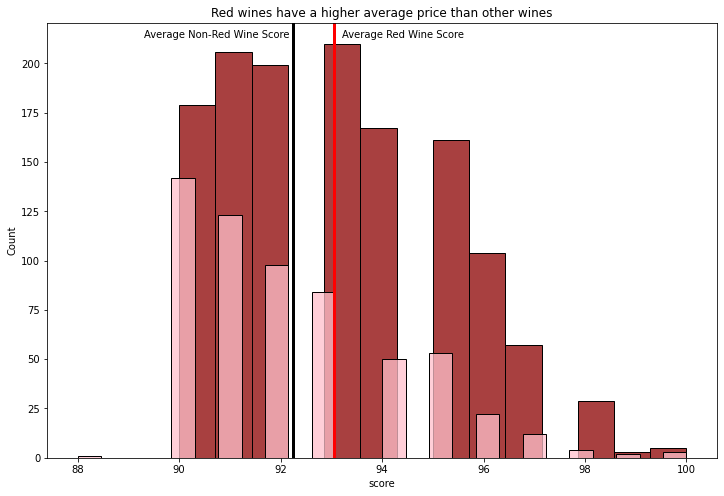

In [195]:
plt.figure(figsize=(12,8))
sns.histplot(data=train[train.red == 1], x='score', color='darkred')
sns.histplot(data=train[train.red == 0], x='score', color='pink')
red_avg = train[train.red == 1].score.mean()
other_avg = train[train.red == 0].score.mean()
plt.axvline(x= red_avg, color='red', lw=3)
plt.text(93.2,213, '''Average Red Wine Score''')
plt.axvline(x=other_avg, color='black', lw=3)
plt.text(89.3,213, '''Average Non-Red Wine Score''')


plt.title('Red wines have a higher average price than other wines')
plt.show()

In the above visuzalization, there is a clear difference in red wines average score and other wines average score. This suggests wines designated as red will score higher.

#### Hypothesis 1 - Red Wine Score
- Ho -> The mean score of red wine is equal to or less than all other wines mean score
- Ha -> The mean score of red wine is greater than all other wines mean score
- T-Test: Two-Sample, One-Tail

In [196]:
reds = train[train.red == 1].score
other = train[train.red == 0].score

α = 0.05

s, pval = stats.levene(reds, other)

t, p = stats.ttest_ind(reds, other, equal_var=pval > α)

# evaluate results based on the t-statistic and the p-value
if ((t > 0) & (p/2 < α)):
    print('''Reject the Null Hypothesis.
Findings suggest the mean score of red wine is greater than the mean score of all other wines. ''')
else:
    print('''Fail to reject the Null Hypothesis.
Findings suggest the mean score of red wine is less than or equal to the mean score of all other wines.''')
print()

Reject the Null Hypothesis.
Findings suggest the mean score of red wine is greater than the mean score of all other wines. 



#### Question 1 Takeaways:
- Red wines score higher than other wines on average
- Most wines score between 90 and 95 points
----

### Question 2: Is there a linear relationship between a wine's price and its score?

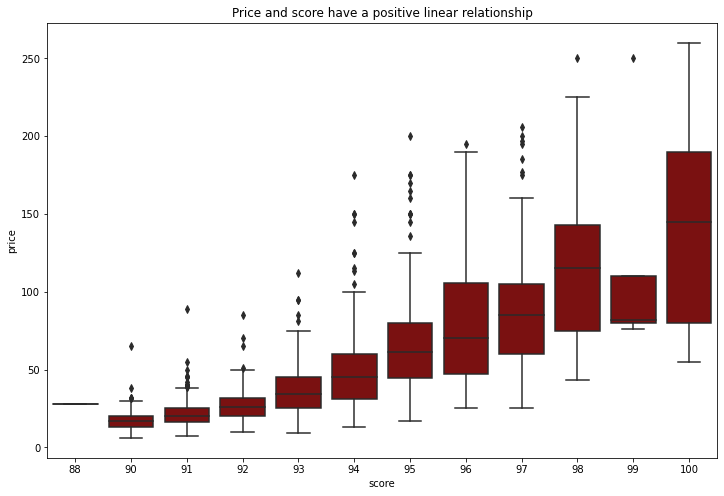

In [88]:
plt.figure(figsize=(12,8))
sns.boxplot(data=train, x='score', y='price', color='darkred')
plt.title('Price and score have a positive linear relationship')
plt.show()

The above visuzalization depicts the increasing price as score also increases. This remains consistent with a score of 99 points being the exception. 

#### Hypothesis 2 - Wine score and price
- Ho -> There is no linear relationship between a wine's score and its price
- Ha -> There is a linear relationship between a wine's score and its price
- Spearman's Correlation due to price not being normally distributed

In [91]:
α = 0.05

r, p = stats.spearmanr(train.price, train.score)

if p < α:
    print('''Reject the Null Hypothesis.
Findings suggest there is a linear relationship between a wine's score and its price.
Spearman's Correlation was: '''+ str(round(r,3)))
else:
    print('''Fail to reject the Null Hypothesis.
Findings suggest there is not a linear relationship between a wine's score and its price.''')
print()

Reject the Null Hypothesis.
Findings suggest there is a linear relationship between a wine's score and its price.
Spearman's Correlation was: 0.795



#### Question 2 Takeaways:
- There is a strong positive linear relationship between a wine's score and its price
----

### Question 3: Do highly scored wines rank higher?

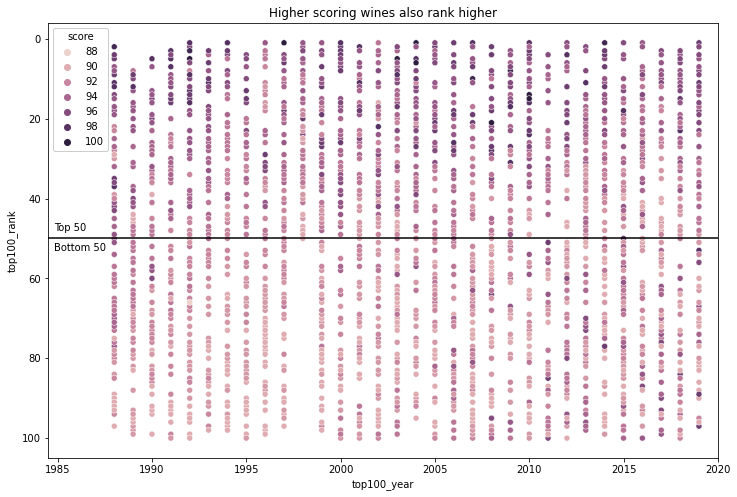

In [280]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=train, x='top100_year', y='top100_rank', hue='score').invert_yaxis()
plt.axhline(50, color='black')
plt.xlim(1984.5,2020)
plt.text(1984.8,48, 'Top 50')
plt.text(1984.8,53, 'Bottom 50')
plt.title('Higher scoring wines also rank higher')
plt.legend(loc='upper left', title='score', framealpha=1)
plt.show()

In the visualization above, you can see the higher scoring wines (darker dots), tend to rank better (closer to #1 spot) year to year

#### Hypothesis 3: Rank and Score
- Ho -> The average score of wines ranking in the top 50 is less than or equal to the average score of wines ranking in the bottom 50
- Ha -> The average score of wines ranking in the top 50 is greater than the average score of wines ranking in the bottom 50
- T-Test: Two-Sample, One-Tail

In [258]:
top = train[train.top100_rank <= 50].score
bottom = train[train.top100_rank > 50].score

α = 0.05

s, pval = stats.levene(top, bottom)

t, p = stats.ttest_ind(top, bottom, equal_var=pval > α)

# evaluate results based on the t-statistic and the p-value
if ((t > 0) & (p/2 < α)):
    print('''Reject the Null Hypothesis.
Findings suggest the mean score of wines ranking in the top 50 is higher.''')
else:
    print('''Fail to reject the Null Hypothesis.
Findings suggest the mean score of wines ranking in the top 50 is lower or equal to the bottom 50.''')
print()

Reject the Null Hypothesis.
Findings suggest the mean score of wines ranking in the top 50 is higher.



#### Question 3 Takeaways:
- The higher ranked wines have a higher average score

### Data Exploration Takeaways

- Red wines score higher than other wines on average
- There is a linear relationship between price and score
- Higher ranked wines have a higher average score

----

## 5. Modeling

In [282]:
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as met
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [295]:
cols = train.columns.tolist()[4:]

In [296]:
cols.append('vintage')

In [299]:
train_scaled, val_scaled, test_scaled = scale_data(train[cols],
                                                   val[cols],
                                                   test[cols],
                                                   cols)

In [300]:
drop_list = [
             'score',
             # 'price',
             'issue_year',
             'top100_year',
             'top100_rank',
             # 'aged',
             # 'France',
             # 'Italy',
             # 'California',
             # 'Spain',
             # 'Australia',
             # 'Washington',
             # 'red',
             # 'white',
             # 'acidity',
             # 'aromas',
             # 'berry',
             # 'best',
             # 'black',
             # 'blackberry',
             # 'cases',
             # 'cherry',
             # 'complex',
             # 'concentrated',
             # 'currant',
             # 'dark',
             # 'drink',
             # 'elegant',
             # 'finish',
             # 'firm',
             # 'flavors',
             # 'fruit',
             # 'fullbodied',
             # 'imported',
             # 'long',
             # 'made',
             # 'mineral',
             # 'notes',
             # 'oak',
             # 'pear',
             # 'plum',
             # 'raspberry',
             # 'rich',
             # 'ripe',
             # 'spice',
             # 'tannins',
             # 'vintage'
]

In [302]:
X_train, y_train = train_scaled.drop(columns=drop_list), train.score
X_val, y_val = val_scaled.drop(columns=drop_list), val.score
X_test, y_test = test_scaled.drop(columns=drop_list), test.score

In [310]:
# baseline_accuracy = y_train.mode()
# print(f'My baseline accuracy is: {round(baseline_accuracy*100, 2)}%.')

In [365]:

thing

,actual,pred
145,90,91
392,90,91
343,93,91
574,91,91
395,90,91
...,...,...
3101,96,91
2494,90,91
1427,94,91
77,91,91


In [372]:
results = {}


# Create baseline metric from mode
thing = pd.DataFrame(train.score)
thing.columns = ['actual']
thing['pred'] = round(train.score.mean())
# Add baseline to results
results['baseline'] = {'train_accuracy': met.accuracy_score(thing.actual,thing.pred),
                        'train_rmse': met.mean_squared_error(thing.actual, thing.pred)
                      }

# Create Logistic Regression Model
logit = LogisticRegression(random_state=123)
# Fit it to the train data
logit.fit(X_train, y_train)
# Run train
logit_accuracy = met.accuracy_score(y_train, logit.predict(X_train))
logit_rmse = met.mean_squared_error(y_train, logit.predict(X_train), squared=False)
# Run validate
val_acc = met.accuracy_score(y_val, logit.predict(X_val))
val_rmse = met.mean_squared_error(y_val, logit.predict(X_val), squared=False)
# Add to results
results['logit'] = {'train_accuracy': logit_accuracy,
                                    'train_rmse': logit_rmse,
                                    'validate_accuracy' : val_acc,
                                    'validate_rmse': val_rmse}
                

# Create Decision Tree model
tree = DecisionTreeClassifier(max_depth=4)
# Fit it
tree.fit(X_train, y_train)
# Add to results
results['tree'] = {'train_accuracy' : met.accuracy_score(y_train, tree.predict(X_train)), 
                                    'train_rmse': met.mean_squared_error(y_train, tree.predict(X_train), squared=False),
                                    'validate_accuracy' : met.accuracy_score(y_val, tree.predict(X_val)), 
                                    'validate_rmse': met.mean_squared_error(y_val, tree.predict(X_val), squared=False)
                    }

# Create Random Forest model
forest = RandomForestClassifier(max_depth=7, min_samples_leaf=5, random_state=123)
# Fit it
forest.fit(X_train, y_train)
# Add to results
results['forest'] = {'train_accuracy' : met.accuracy_score(y_train, forest.predict(X_train)), 
                            'train_rmse': met.mean_squared_error(y_train, forest.predict(X_train), squared=False),
                            'validate_accuracy' : met.accuracy_score(y_val, forest.predict(X_val)), 
                            'validate_rmse': met.mean_squared_error(y_val, forest.predict(X_val), squared=False)
                          }


pd.DataFrame(results).T

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,train_accuracy,train_rmse,validate_accuracy,validate_rmse
baseline,0.153605,4.824974,NaN,NaN
logit,0.341693,1.676252,0.267606,1.819302
tree,0.387670,1.412550,0.352113,1.388529
forest,0.606061,1.293824,0.348983,1.566472


In [374]:
results, final = model.run_models(train, val, test)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [380]:
results.T

,baseline,logit,tree,forest
train_accuracy,0.153605,0.341693,0.387670,0.606061
train_rmse,4.824974,1.676252,1.412550,1.293824
validate_accuracy,NaN,0.267606,0.352113,0.348983
validate_rmse,NaN,1.819302,1.388529,1.566472


In [379]:
pd.DataFrame(final)

,tree
test_accuracy,0.325509
test_rmse,1.565473
train_accuracy,0.387670
train_rmse,1.412550
validate_accuracy,0.352113
validate_rmse,1.388529


#### Modeling Takeaways
Stuff

----

## CONCLUSION
Main statement

#### Recommendations
- thing 
- stuff 

#### Next Steps
- thing
- stuff

----